In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qutip import *
class o:pass

#### 1. Operators and System
In this script we consinder the joint space of:
- a cavity supporting mode $a$ containing a single two-level atom with:
    - cavity resonant frequency $\omega_c$
    - cavity leakage rate $\kappa$
    - atom transition frquency $\omega_L$
    - field coupling strength $g$
    - atom spontaneous emission rate $\gamma$
- a N dimensional space of photon field $\mathcal{E}$

Operators in the joint space are constructed form tensor products of the corresponding constituting-space operators:

In [2]:
def operators(kappa, gamma, N):
    # input: various parameters 
    # output: a dictionary of joint operators for the system

    # Anhilation Operators
    a  = tensor(destroy(N), qeye(2))    # a - cavity lowering operator
    sm = tensor(qeye(N), destroy(2))    # sigma - atomic lowering operator

    # Collapse Operators
    C1 = np.sqrt(2*kappa)*a
    C2 = np.sqrt(gamma)*sm
    C1dC1 = C1.dag() * C1
    C2dC2 = C2.dag() * C2

    return locals()

def Hamil( E, g, Del_c, sm, a ):
    # Hamiltonian
    H0 = Del_c * sm.dag() * sm + Del_c * a.dag() * a
    H_c = g*(a.dag()*sm + sm.dag()*a)
    H_e = E*(a.dag()+a)

    H = H0 + H_c + H_e
    return H

#### 2. Superoperators and density matrix equations
The evolution of a system's density matrix $\rho$ is ruled by the master equation: $d\rho/dt = \hat{\mathcal{L}}\rho$. Where the superoperator Liouvillian $\hat{\mathcal{L}}_{\hat{H}\rho}$ for our joint system (including the Hamiltonian commutator) is given by:
$$
\hat{\mathcal{L}} \rho = 
-i(\hat{H}\rho-\rho\hat{H} ) +
\sum^{2}_{k=1}\hat{C}_k \rho \hat{C}_k^{\dagger} 
- \frac{1}{2}\left( \hat{C}_k^{\dagger}\hat{C}_k\rho + \rho\hat{C}_k\hat{C}_k^{\dagger} \right)
$$
Where the collapse operators: 
- $C_1 = \sqrt{2\kappa}\hat{a}$ is the collapse operator for photons
- $C_2 = \sqrt{\gamma}\hat{\sigma}_-$  is the collapse operator for the atom

When operating $\hat{\mathcal{L}}$ on matrix $\rho$, we perform calculations 'flatly' to obtain $\widetilde{\mathcal{L}\rho}$. This is done by utilizing the spre() and spost() functions in QuTiP that acts as such: $ \widetilde{ab} = spre(a)\:\widetilde{b} = spost(b)\:\widetilde{a} $. These steps are performed in the following function:

In [3]:
def Liouv( H, C1, C2, C1dC1, C2dC2 ):

    LH = -1j * (spre(H) - spost(H))
    L1 = spre(C1)*spost(C1.dag()) - 0.5*spre(C1dC1) - 0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag()) - 0.5*spre(C2dC2) - 0.5*spost(C2dC2)

    L = LH+L1+L2
    return L 

#### 3. Calculating Operator expectation values
The expectation value of some operator in the system can be obtained from the QuTiP function expect(op,s) where s can either be a state ket vector or a density matrix. In this specific example, we can obtain the steady state solution of density matrix $\rho$ in the master equation using the steady() function.

#### 3.1 Photocount rates vs Detuning

In [4]:
kappa = 2
gamma = 0.2
N = 5

g = 1
E = 0.5

op_dict = operators(kappa, gamma, N)
for k,v in op_dict.items():
    setattr(o, k, v)

Del_c_vec = np.linspace(-5,5,201)
count1 = []
count2 = []

for Del_c in Del_c_vec:
    H = Hamil( E, g, Del_c, o.sm, o.a )
    L = Liouv( H, o.C1, o.C2, o.C1dC1, o.C2dC2 )
    rhoss = steady(L)

    count1.append(expect(o.C1dC1,rhoss))
    count2.append(expect(o.C2dC2,rhoss))


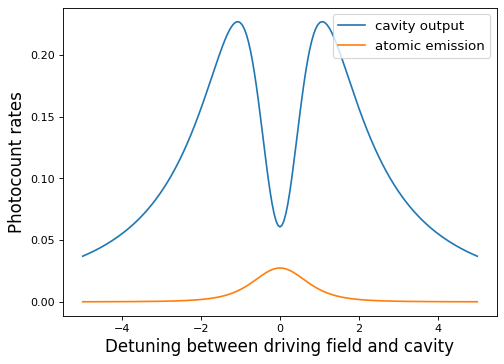

In [9]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7,5), dpi=80)
ax1.plot(Del_c_vec,np.real(count1), label='cavity output')
ax1.plot(Del_c_vec,np.real(count2), label='atomic emission')
ax1.set_xlabel('Detuning between driving field and cavity', fontsize = 15)
ax1.set_ylabel('Photocount rates', fontsize = 15)
ax1.legend(fontsize = 12)

#### 3.2 intracavity field phase shift vs detuning

In [6]:
kappa = 2
gamma = 0.2
g = 1
N = 5
op_dict = operators(kappa, gamma, N)
for k,v in op_dict.items():
    setattr(o, k, v)

E_vec = np.linspace(0.05,0.85,3)
Del_c_vec = np.linspace(-5,5,201)
infield_lst = []

for E in E_vec:

    infield = []

    for Del_c in Del_c_vec:
        H = Hamil( E, g, Del_c, o.sm, o.a )
        L = Liouv( H, o.C1, o.C2, o.C1dC1, o.C2dC2 )
        rhoss = steady(L)

        infield.append(expect(o.a,rhoss))

    infield_lst.append(infield) 

infield_lst = np.angle(infield_lst)

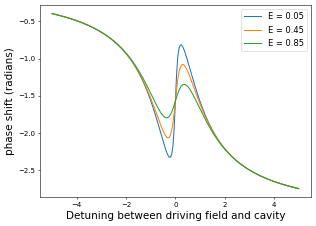

In [7]:
fig2, ax2 = plt.subplots(1, 1, figsize=(7,5), dpi=50)
i=0
for E in E_vec:
    ax2.plot(Del_c_vec, infield_lst[i], label = 'E = {:.2f}'.format(E))
    i += 1

ax2.set_xlabel('Detuning between driving field and cavity', fontsize = 15)
ax2.set_ylabel('phase shift (radians)', fontsize = 15)
ax2.legend(fontsize = 12)

#### 4. Orbital Angular Momentum States
showcases the use of orbital() and sphereplot() functions

(<Figure size 490x350 with 2 Axes>, <Axes3DSubplot:>)

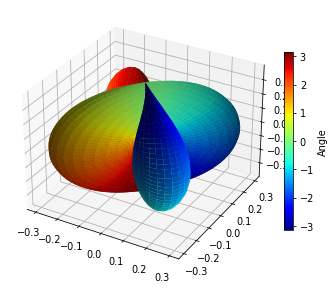

In [8]:
theta = np.linspace(0,np.pi,45)
phi = np.linspace(0,2*np.pi,90)
c2 = basis(5,1)
psi = orbital(theta,phi,c2)
fig3 = plt.figure(figsize=(7,5), dpi=70)
ax3 = fig3.add_subplot(projection='3d')
sphereplot(phi, theta, psi, fig3, ax3)